In [0]:
import torch
import torch.nn  as  nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd

## prepare corpus

In [0]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [0]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [0]:
corpus = remove_stop_words(corpus)

In [0]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

In [0]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [7]:
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [8]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [9]:
word2int

{'boy': 10,
 'girl': 8,
 'king': 9,
 'man': 0,
 'pretty': 6,
 'prince': 5,
 'princess': 2,
 'queen': 1,
 'strong': 7,
 'wise': 11,
 'woman': 3,
 'young': 4}

In [0]:
ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

X = torch.Tensor(X)
Y = torch.Tensor(Y)

In [11]:
X[:4], Y[:4]

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

## Modeling

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
device

'cuda'

In [0]:
# Implementation in Linear layer
class Word2VecWithLinear(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2VecWithLinear, self).__init__()
        self.l1 = nn.Linear(vocab_size, embedding_size)
        self.l2 = nn.Linear(embedding_size, vocab_size)

    def forward(self, context_word):
        # context_word must be one-hot encoded
        # ex) [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
        x = self.l1(context_word)
        x = self.l2(x)
        return x

# Implementation in Embedding layer
class Word2VecWithEmbedding(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2VecWithEmbedding, self).__init__()
        self.emb = nn.Embedding(vocab_size, embedding_size)
        self.l2 = nn.Linear(embedding_size, vocab_size)

    def forward(self, context_word):
        # context_word must be one-hot encoded
        # ex) [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
        index = context_word.long().argmax() # get index label
        x = self.emb(index)
        x = self.l2(x)
        return x

In [0]:
model_1 = Word2VecWithLinear(2, ONE_HOT_DIM).to(device)
model_2 = Word2VecWithEmbedding(2, ONE_HOT_DIM).to(device)

In [0]:
optimizer_1 = optim.Adam(model_1.parameters())
optimizer_2 = optim.Adam(model_2.parameters()) 
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss()

train two model at once

In [17]:
EPOCHS = 1000
for epoch in range(EPOCHS):
    train_loss_1 = 0
    train_loss_2 = 0
    for x, y in zip(X, Y):
        model_1.zero_grad()
        model_2.zero_grad()
        input = x.to(device)
        target = y.to(device)
        output_1 = model_1(input)
        output_2 = model_2(input)

        loss_1 = criterion_1(output_1.unsqueeze(0), target.long().argmax().view(-1))
        loss_1.backward()
        loss_2 = criterion_2(output_2.unsqueeze(0), target.long().argmax().view(-1))
        loss_2.backward()

        optimizer_1.step()
        optimizer_2.step()

        batch_loss_1 = loss_1.item()
        train_loss_1 += batch_loss_1        
        batch_loss_2 = loss_2.item()
        train_loss_2 += batch_loss_2

    if epoch % 50 ==0:
        print(train_loss_1)
        print(train_loss_2)

132.04049241542816
140.946040391922
117.42888677120209
114.32701992988586
109.96578884124756
106.29316771030426
105.98914420604706
101.6908050775528
103.66302239894867
98.60514307022095
102.03041279315948
96.30848062038422
100.6804850101471
94.51500952243805
99.46794998645782
93.31603264808655
98.35454273223877
92.54763555526733
97.31624627113342
92.00671875476837
96.29803550243378
91.59551417827606
95.2103853225708
91.26225876808167
93.97252094745636
90.97587883472443
92.67914974689484
90.71520709991455
91.6533533334732
90.46447157859802
90.98368561267853
90.21202981472015
90.53340899944305
89.95105195045471
90.20182573795319
89.68077790737152
89.93857157230377
89.40685176849365
89.71683061122894
89.1392468214035


In [0]:
wordvec_w = model_1.cpu().l1.weight.detach().numpy()
wordvec_b = model_1.cpu().l1.bias.detach().numpy()
wordvec_1 = np.add(wordvec_w, wordvec_b.reshape(-1, 1))

wordvec_2 = model_2.cpu().emb.weight.detach().numpy()

In [0]:
int2word = {v: k for k, v in word2int.items()}

In [0]:
from matplotlib import pyplot as plt

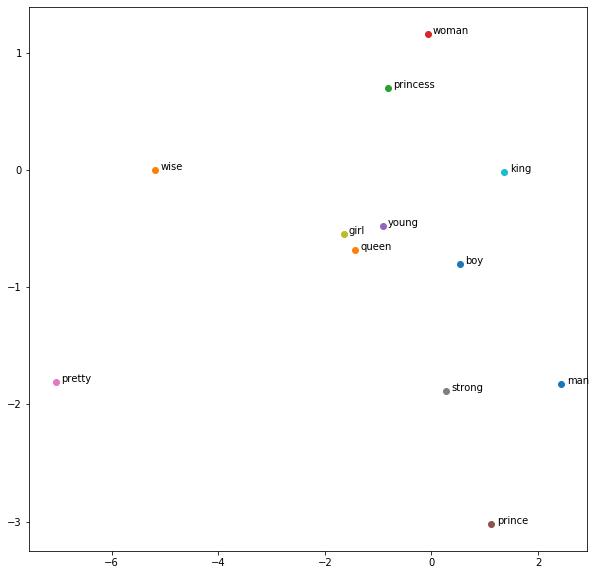

In [21]:
plt.figure(figsize=(10, 10))

Xpos = wordvec_1[0]
Ypos = wordvec_1[1]
i = 0
for x, y in zip(Xpos, Ypos):
    plt.scatter(x, y)
    plt.text(x+0.1, y, int2word[i], fontsize=10)
    i+=1

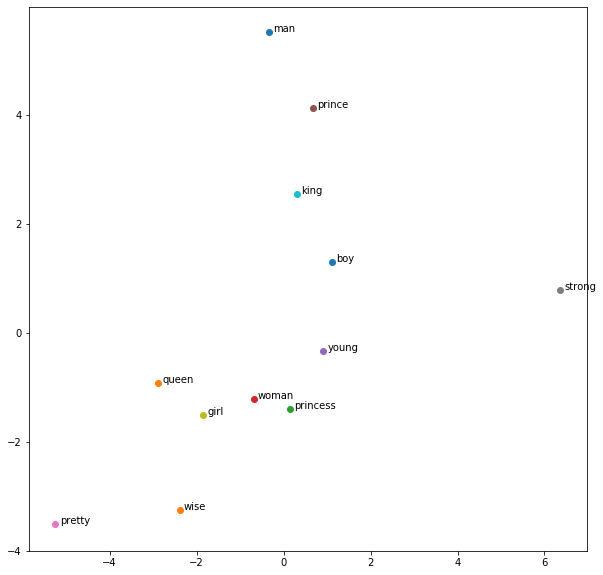

In [22]:
plt.figure(figsize=(10, 10))

Xpos = wordvec_2.T[0]
Ypos = wordvec_2.T[1]
i = 0
for x, y in zip(Xpos, Ypos):
    plt.scatter(x, y)
    plt.text(x+0.1, y, int2word[i], fontsize=10)
    i+=1